# Setup

In [1]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)
# print("cwd is now:", Path.cwd())

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from data_loader import scores_df, df_model
from fit import fit_statistical_model
import statsmodels.api as sm
from scipy.stats import linregress
from scipy.optimize import least_squares
from typing import Union, Optional
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import seaborn as sns

null performances after coercion: 281
after saturation filter 2201
after filter num benchmarks 1401
after merge with model versions 1406
after merge with benchmark dates 1406
Original number of rows: 1406
Number of rows after aggregation: 971


In [3]:
# MODIFIED: Added anchor_slope and anchor_difficulty to the function signature.
def split_params(params: np.ndarray, num_models: int, num_benchmarks: int, anchor_idx: int, model_type: str, anchor_slope: float, anchor_difficulty: float):
    """
    Breaks the flat parameter vector into C, D, full-length α,
    and gammas (for sigmoid_with_offsets).
    """
    C = params[:num_models]

    # MODIFICATION: Reconstruct D by inserting the fixed anchor difficulty.
    # The optimizer only solves for the other N-1 difficulties.
    D_free = params[num_models : num_models + num_benchmarks - 1]
    D = np.insert(D_free, anchor_idx, anchor_difficulty)

    # MODIFICATION: Adjust index for alpha and insert the fixed anchor slope.
    alpha_free = params[num_models + num_benchmarks - 1 : num_models + 2 * num_benchmarks - 2]
    alpha = np.insert(alpha_free, anchor_idx, anchor_slope)

    # Handle parameters specific to the 'sigmoid_with_offsets' model
    if model_type == 'sigmoid_with_offsets':
        # MODIFICATION: Adjust indices for gamma parameters.
        gamma_lower = params[num_models + 2 * num_benchmarks - 2 : num_models + 3 * num_benchmarks - 2]
        gamma_upper = params[num_models + 3 * num_benchmarks - 2:]
        return C, D, alpha, gamma_lower, gamma_upper

    return C, D, alpha

# MODIFIED: Added anchor_slope and anchor_difficulty to the function signature.
def predict(params, model_idx, bench_idx, num_models, num_benchmarks, anchor_idx, model_type, anchor_slope, anchor_difficulty):
    """Calculates predictions based on the specified model type."""
    # Unpack the parameters based on the model type
    # MODIFICATION: Pass anchor values to split_params
    split_args = (params, num_models, num_benchmarks, anchor_idx, model_type, anchor_slope, anchor_difficulty)
    if model_type == 'sigmoid_with_offsets':
        C, D, alpha, lower_asymptote, upper_asymptote = split_params(*split_args)
    else:
        C, D, alpha = split_params(*split_args)

    # Core prediction logic
    x = alpha[bench_idx] * (C[model_idx] - D[bench_idx])

    # Apply the correct functional form
    if model_type == 'clipped_linear':
        return np.clip(x, 0, 1)
    elif model_type == 'sigmoid_with_offsets':
        return lower_asymptote[bench_idx] + (upper_asymptote[bench_idx] - lower_asymptote[bench_idx]) / (1 + np.exp(-x))
    else:  # Default to 'sigmoid'
        return 1.0 / (1.0 + np.exp(-x))

def calculate_metrics(y_true, y_pred, num_params):
    """
    Calculates R-squared, MSE, AIC, and BIC.
    """
    n_obs = len(y_true)
    rss = np.sum((y_true - y_pred) ** 2)
    mse = rss / n_obs
    tss = np.sum((y_true - np.mean(y_true)) ** 2)
    r2 = 1 - (rss / tss) if tss > 0 else 0
    aic = n_obs * np.log(mse) + 2 * num_params if mse > 0 else -np.inf
    bic = n_obs * np.log(mse) + num_params * np.log(n_obs) if mse > 0 else -np.inf
    return {'r2': r2, 'mse': mse, 'aic': aic, 'bic': bic}

--- Starting Repetition 1/100 ---
Dropping 9 benchmarks: ['OSWorld', 'GeoBench', 'GPQA diamond', 'OSUniverse', 'Aider polyglot', 'OTIS Mock AIME 2024-2025', 'ANLI', 'FrontierMath-2025-02-28-Private', 'Terminal Bench']
`ftol` termination condition is satisfied.
Function evaluations 38, initial cost 2.1758e+01, final cost 1.4524e+00, first-order optimality 4.88e-04.
Slope for this repetition: 0.3829 capability units / year
----------------------------------------
--- Starting Repetition 2/100 ---
Dropping 9 benchmarks: ['VideoMME', 'OSUniverse', 'CadEval', 'DeepResearch Bench', 'Cybench', 'HellaSwag', 'Balrog', 'GPQA diamond', 'ARC-AGI']
`ftol` termination condition is satisfied.
Function evaluations 28, initial cost 2.7904e+01, final cost 1.9522e+00, first-order optimality 3.55e-04.
Slope for this repetition: 0.4152 capability units / year
----------------------------------------
--- Starting Repetition 3/100 ---
Dropping 9 benchmarks: ['WeirdML', 'OTIS Mock AIME 2024-2025', 'ARC AI2', 

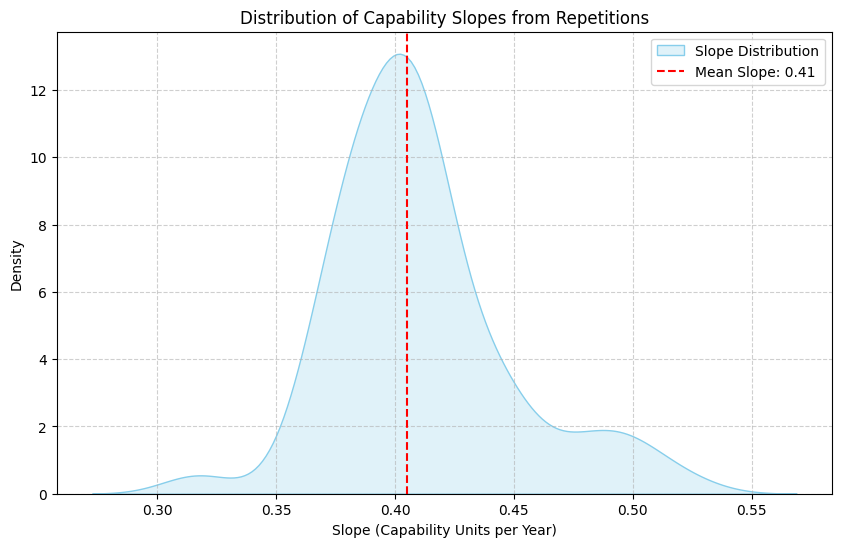

In [4]:
import random
random.seed(42)

def run_analysis():
    # 1. Initial Setup
    n_repetitions = 100 #100
    fraction_to_drop = 0.3
    anchor_benchmark = "Winogrande"
    cutoff_date = pd.Timestamp("2010-01-01") #pd.Timestamp("2023-01-01")
    slopes_per_repetition = []

    # 2. Main Loop
    for i in range(n_repetitions):
        print(f"--- Starting Repetition {i + 1}/{n_repetitions} ---")

        if scores_df.empty or df_model.empty:
            print("Dataframes `scores_df` or `df_model` not loaded. Halting script.")
            return

        # a. Randomly drop benchmarks
        all_unique_benchmarks = list(scores_df['benchmark'].unique())
        eligible_to_drop = [b for b in all_unique_benchmarks if b != anchor_benchmark]
        num_benchmarks_to_drop = int(len(all_unique_benchmarks) * fraction_to_drop)
        k = min(num_benchmarks_to_drop, len(eligible_to_drop))
        benchmarks_to_drop = random.sample(eligible_to_drop, k=k) if k > 0 else []
        print(f"Dropping {len(benchmarks_to_drop)} benchmarks: {benchmarks_to_drop}")
        scores_df_dropped = scores_df[~scores_df['benchmark'].isin(benchmarks_to_drop)].copy()

        # b. Fit statistical model
        # _, df_cm_dropped, _ = fit_statistical_model(scores_df_dropped, anchor_benchmark, 0, 1, df_model=df_model)
        _, df_cm_dropped, _ = fit_statistical_model(scores_df_dropped, 
                         anchor_mode="benchmark",  # "benchmark" or "model"
                         # Benchmark anchoring parameters
                         anchor_benchmark=anchor_benchmark, 
                         anchor_difficulty=0, 
                         anchor_slope=1.0,
                         slope_init=1.0,
                         regularization_strength=0.1,  # NEW: Add L2 regularization
                         df_model=df_model)

        # c. Prepare data for linear fit
        df_cm_dropped.dropna(subset=['date'], inplace=True)
        if df_cm_dropped.empty:
            print("No models with valid dates remaining. Skipping repetition.")
            print("-" * 40)
            continue

        df_cm_dropped['date_obj'] = pd.to_datetime(df_cm_dropped['date'])
        fit_df = df_cm_dropped[df_cm_dropped['date_obj'] >= cutoff_date].copy()

        # d. Fit linear model
        if len(fit_df) < 2:
            print("Not enough data points after cutoff to fit a line. Skipping repetition.")
            print("-" * 40)
            continue

        dates_num = mdates.date2num(fit_df["date_obj"])
        capabilities = fit_df["estimated_capability"].values.astype(float)
        X = dates_num.reshape(-1, 1)
        y = capabilities
        lin_reg = LinearRegression().fit(X, y)
        slope_per_year = lin_reg.coef_[0] * 365
        slopes_per_repetition.append(slope_per_year)
        print(f"Slope for this repetition: {slope_per_year:.4f} capability units / year")
        print("-" * 40)

    # 3. Final Summary and Plot
    print("\n--- Overall Summary ---")
    if slopes_per_repetition:
        median_slope = np.median(slopes_per_repetition)
        std_slope = np.std(slopes_per_repetition)

        print(f"Slopes from {len(slopes_per_repetition)} successful repetitions:")
        print([round(s, 4) for s in slopes_per_repetition])
        print(f"\nMedian slope: {median_slope:.4f}")
        print(f"Standard deviation of slopes: {std_slope:.4f}")

        # Create the KDE plot
        plt.figure(figsize=(10, 6))
        sns.kdeplot(slopes_per_repetition, fill=True, color='skyblue', label='Slope Distribution')
        plt.axvline(median_slope, color='red', linestyle='--', label=f'Mean Slope: {median_slope:.2f}')

        plt.title('Distribution of Capability Slopes from Repetitions')
        plt.xlabel('Slope (Capability Units per Year)')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()

    else:
        print("No slopes were calculated. Check data and cutoff date.")

# Run the entire analysis
run_analysis()

In [5]:
x = [np.float64(0.3829), np.float64(0.4152), np.float64(0.3788), np.float64(0.3775), np.float64(0.4412), np.float64(0.4168), np.float64(0.437), np.float64(0.4434), np.float64(0.4076), np.float64(0.3999), np.float64(0.389), np.float64(0.4052), np.float64(0.4047), np.float64(0.4089), np.float64(0.3855), np.float64(0.3661), np.float64(0.4049), np.float64(0.3935), np.float64(0.4118), np.float64(0.3779), np.float64(0.4257), np.float64(0.3814), np.float64(0.3172), np.float64(0.4083), np.float64(0.3856), np.float64(0.4758), np.float64(0.3629), np.float64(0.3173), np.float64(0.369), np.float64(0.3689), np.float64(0.4055), np.float64(0.4154), np.float64(0.4027), np.float64(0.401), np.float64(0.4127), np.float64(0.3985), np.float64(0.414), np.float64(0.503), np.float64(0.4408), np.float64(0.3865), np.float64(0.3782), np.float64(0.4073), np.float64(0.4046), np.float64(0.4133), np.float64(0.4029), np.float64(0.3791), np.float64(0.4593), np.float64(0.4417), np.float64(0.4195), np.float64(0.4981), np.float64(0.3823), np.float64(0.3815), np.float64(0.4222), np.float64(0.4079), np.float64(0.4186), np.float64(0.3933), np.float64(0.3935), np.float64(0.4372), np.float64(0.4041), np.float64(0.443), np.float64(0.3696), np.float64(0.3783), np.float64(0.4211), np.float64(0.3934), np.float64(0.4098), np.float64(0.3993), np.float64(0.5105), np.float64(0.4868), np.float64(0.4957), np.float64(0.5243), np.float64(0.3902), np.float64(0.4776), np.float64(0.4744), np.float64(0.4181), np.float64(0.3757), np.float64(0.3884), np.float64(0.3676), np.float64(0.3852), np.float64(0.3842), np.float64(0.3686), np.float64(0.4468), np.float64(0.4041), np.float64(0.3983), np.float64(0.4117), np.float64(0.4531), np.float64(0.4071), np.float64(0.3851), np.float64(0.4161), np.float64(0.4263), np.float64(0.3899), np.float64(0.415), np.float64(0.3868), np.float64(0.4036), np.float64(0.3941), np.float64(0.4121), np.float64(0.4462), np.float64(0.4922), np.float64(0.415), np.float64(0.4136), np.float64(0.3666)]
np.percentile(x, [2.5, 50, 97.5])

array([0.36442  , 0.40505  , 0.5006725])

In [10]:
# Rank correlation analysis: stability of model ranks across subsets (standard model-anchored fit)
from scipy.stats import spearmanr
from IPython.display import display

# Standard anchors (as used in other notebooks)
ANCHOR_MODEL1 = "claude-3-opus-20240229"
ANCHOR_MODEL1_CAP = 1.510032
ANCHOR_MODEL2 = "claude-opus-4-20250514"
ANCHOR_MODEL2_CAP = 2.015441


def fit_and_get_model_ranks_standard(df_in):
    # Require anchors to be present in this subset; otherwise skip
    models_present = set(df_in["model"].unique())
    if not ({ANCHOR_MODEL1, ANCHOR_MODEL2} <= models_present):
        return None, None

    _, model_caps, _ = fit_statistical_model(
        df_in,
        anchor_mode="model",
        anchor_model1=ANCHOR_MODEL1,
        anchor_model1_capability=ANCHOR_MODEL1_CAP,
        anchor_model2=ANCHOR_MODEL2,
        anchor_model2_capability=ANCHOR_MODEL2_CAP,
        slope_init=1.0,
        regularization_strength=0.1,
        df_model=df_model,
    )

    model_ranks = (
        model_caps[["model", "estimated_capability"]]
        .dropna(subset=["estimated_capability"])
        .assign(rank=lambda d: d["estimated_capability"].rank(ascending=False, method="average"))
        [["model", "rank"]]
    )
    return model_caps, model_ranks


def compute_model_rank_spearman(base_model_ranks, sub_model_ranks):
    m = base_model_ranks.merge(sub_model_ranks, on="model", suffixes=("_base", "_sub"))
    if len(m) < 2:
        return np.nan, len(m)
    rho = spearmanr(m["rank_base"].to_numpy(), m["rank_sub"].to_numpy(), nan_policy="omit").correlation
    return rho, len(m)


def run_rank_correlation_analysis(
    n_repetitions: int = 30,
    fraction_to_drop: float = 0.3,
    random_seed: int = 123,
):
    rng = np.random.default_rng(random_seed)

    # Baseline (all benchmarks) using standard model-anchored fit
    base_caps, base_model_ranks = fit_and_get_model_ranks_standard(scores_df)
    if base_caps is None:
        print("Baseline missing anchor models; cannot compute baseline ranks.")
        return

    all_benchmarks = list(scores_df["benchmark"].unique())
    eligible_to_drop = [b for b in all_benchmarks]
    k_drop = max(0, int(len(all_benchmarks) * fraction_to_drop))

    spearmans = []
    n_models_used = []
    skipped = 0

    for _ in range(n_repetitions):
        drop_k = min(k_drop, len(eligible_to_drop))
        to_drop = rng.choice(eligible_to_drop, size=drop_k, replace=False) if drop_k > 0 else []
        df_sub = scores_df[~scores_df["benchmark"].isin(to_drop)].copy()

        sub_caps, sub_model_ranks = fit_and_get_model_ranks_standard(df_sub)
        if sub_caps is None:
            skipped += 1
            continue

        rho, n_used = compute_model_rank_spearman(base_model_ranks, sub_model_ranks)
        spearmans.append(rho)
        n_models_used.append(n_used)

    if spearmans:
        print("Model rank Spearman vs baseline (random subsets, standard fit):")
        print("  per-run:", [None if np.isnan(x) else round(float(x), 3) for x in spearmans])
        print(f"  median={np.nanmedian(spearmans):.3f}, IQR=[{np.nanpercentile(spearmans,25):.3f}, {np.nanpercentile(spearmans,75):.3f}]")
        print(f"  models compared per run (median)={int(np.nanmedian(n_models_used))}; skipped runs due to missing anchors={skipped}")
    else:
        print("No valid runs. Anchors likely dropped too often.")

    # Build table rows
    rows = []

    # Add baseline row (full dataset vs. itself)
    rows.append({
        "subset": "fullsubset",
        "models_spearman": 1.0,
        "models_spearman_iqr_low": np.nan,
        "models_spearman_iqr_high": np.nan,
        "n_models_compared": len(base_model_ranks),
        "n_benchmarks": scores_df["benchmark"].nunique(),
        "n_models": scores_df["model"].nunique(),
        "notes": "baseline"
    })

    # Add random subsets summary row
    if spearmans:
        rows.append({
            "subset": "random_subsets",
            "models_spearman": float(np.nanmedian(spearmans)),
            "models_spearman_iqr_low": float(np.nanpercentile(spearmans, 25)),
            "models_spearman_iqr_high": float(np.nanpercentile(spearmans, 75)),
            "n_models_compared": int(np.nanmedian(n_models_used)) if len(n_models_used) else 0,
            "n_benchmarks": scores_df["benchmark"].nunique(),  # varies per run; show total for reference
            "n_models": scores_df["model"].nunique(),
            "notes": f"reps={len(spearmans)}, skipped={skipped}"
        })

    # Metadata-defined subsets (optional): compute single Spearman per subset
    subsets = {
        "math_only": scores_df[scores_df.get("is_math", False).fillna(False)],
        "coding_only": scores_df[scores_df.get("is_coding", False).fillna(False)],
        "optimized_only": scores_df[scores_df.get("optimized", False).fillna(False)],
        "non_math": scores_df[~scores_df.get("is_math", False).fillna(False)],
        "non_coding": scores_df[~scores_df.get("is_coding", False).fillna(False)],
        "non_optimized": scores_df[~scores_df.get("optimized", False).fillna(False)],
    }

    for name, df_sub in subsets.items():
        if df_sub["benchmark"].nunique() < 3 or df_sub["model"].nunique() < 3:
            rows.append({
                "subset": name,
                "models_spearman": np.nan,
                "models_spearman_iqr_low": np.nan,
                "models_spearman_iqr_high": np.nan,
                "n_models_compared": 0,
                "n_benchmarks": df_sub["benchmark"].nunique(),
                "n_models": df_sub["model"].nunique(),
            })
            continue
        sub_caps, sub_model_ranks = fit_and_get_model_ranks_standard(df_sub)
        if sub_caps is None:
            rows.append({
                "subset": name,
                "models_spearman": np.nan,
                "models_spearman_iqr_low": np.nan,
                "models_spearman_iqr_high": np.nan,
                "n_models_compared": 0,
                "n_benchmarks": df_sub["benchmark"].nunique(),
                "n_models": df_sub["model"].nunique(),
            })
            continue
        rho, n_used = compute_model_rank_spearman(base_model_ranks, sub_model_ranks)
        rows.append({
            "subset": name,
            "models_spearman": rho,
            "models_spearman_iqr_low": np.nan,
            "models_spearman_iqr_high": np.nan,
            "n_models_compared": n_used,
            "n_benchmarks": df_sub["benchmark"].nunique(),
            "n_models": df_sub["model"].nunique(),
        })

    subset_summary = pd.DataFrame(rows).sort_values("subset").reset_index(drop=True)
    print("\nModel rank Spearman vs baseline (standard fit): full, random subsets, and metadata-defined subsets")
    display(subset_summary)


# Run the analysis
run_rank_correlation_analysis(
    n_repetitions=30,
    fraction_to_drop=0.3,
    random_seed=123,
)


`ftol` termination condition is satisfied.
Function evaluations 23, initial cost 3.4534e+01, final cost 2.6192e+00, first-order optimality 4.26e-04.
`ftol` termination condition is satisfied.
Function evaluations 38, initial cost 2.0867e+01, final cost 1.3465e+00, first-order optimality 1.14e-04.
`ftol` termination condition is satisfied.
Function evaluations 28, initial cost 2.4183e+01, final cost 1.8996e+00, first-order optimality 6.64e-04.
`ftol` termination condition is satisfied.
Function evaluations 33, initial cost 2.5514e+01, final cost 1.5023e+00, first-order optimality 3.18e-05.
`ftol` termination condition is satisfied.
Function evaluations 24, initial cost 2.4422e+01, final cost 1.7299e+00, first-order optimality 3.09e-04.
`ftol` termination condition is satisfied.
Function evaluations 26, initial cost 2.0161e+01, final cost 1.7100e+00, first-order optimality 5.53e-04.
`ftol` termination condition is satisfied.
Function evaluations 42, initial cost 2.1793e+01, final cost 1.

,subset,models_spearman,models_spearman_iqr_low,models_spearman_iqr_high,n_models_compared,n_benchmarks,n_models,notes
0,coding_only,0.758578,NaN,NaN,56,7,56,NaN
1,fullsubset,1.000000,NaN,NaN,151,31,150,baseline
2,math_only,0.983661,NaN,NaN,85,3,82,NaN
3,non_coding,0.998204,NaN,NaN,153,24,150,NaN
4,non_math,0.986772,NaN,NaN,153,28,150,NaN
5,non_optimized,0.883865,NaN,NaN,128,12,125,NaN
6,optimized_only,0.993034,NaN,NaN,153,19,150,NaN
7,random_subsets,0.987415,0.980306,0.992212,153,31,150,"reps=30, skipped=0"
